# **IMPORTS**

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import heapq
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce 

## **COVARIANCE MATRIX**

Returns expected return of the portfolio (mean) and the standard deviation of the portfolio (std), as well since they are used to compute Sharpe Ratio.

In [4]:
def covariance_matrix(data, weights):

    print("Inside covariance_matrix")
    returns = np.log(data / data.shift(1)).dropna()

    mean_returns = returns.mean()
    
    # Portfolio expected return
    expected_return = np.dot(weights, mean_returns)
    cov_matrix = returns.cov()
    portfolio_std_dev = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))
    
    return returns.cov(), expected_return, portfolio_std_dev

## **SHARPE RATIO**

How should we rank different strategies? One technique might yield a large
return one year, and large losses the next. Another might have smaller
returns, but less variations. 

-----------------------------------------------------------

In order to compare different strategies, some performance metrics are defined such *Sharpe Ratio* and *Calmar Ratio*. In this project, the **Sharpe Ratio** is used to compare different prortfolios.

The **Sharpe Ratio** is the ratio of excess annualized returns over annualized
standard deviation of returns σ. By excess returns, we mean returns over
the riskless rate r0. The Sharpe Ratio gives a measure of how much portfolio returns fluctuate over a given period.

        SR = (r − r0)/σ     


In [5]:
def sharpe_ratio(expected_return, portfolio_std, risk_free_rate=0.03):

    sharpe = (expected_return - risk_free_rate) / portfolio_std

    return sharpe



## **GENETIC ALGORITHM**

* **Gene (Scalar)** --> Weight

* **Chromosome (1D Array)** --> Set of Genes --> Set of Weights

    Sum of the chromose array should be equal to 1 since it is total weights in a portfolio.

* **Initial Population (2D Array)** --> Set of chromosomes

-------------------------------------------------
-------------------------------------------------
-------------------------------------------------


# **APPLICATION**

In [7]:
tickers = ["NVDA", "AAPL", "MSFT", "AMZN", "META"]
start_date = "2024-01-01"
end_date = "2024-08-28"
data = yf.download(tickers, start=start_date, end=end_date)['Close']
rf = 0.03

benchmark = yf.download('^OEX', start=start_date, end=end_date)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
print("--------------------DATA------------------")
print(data.shape)
display(data.head())

--------------------DATA------------------
(165, 5)


Ticker,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2024-01-02,184.532074,149.929993,344.972260,367.380615,48.154346
2024-01-03,183.150375,148.470001,343.159180,367.113159,47.555519
2024-01-04,180.824371,144.570007,345.799072,364.478210,47.984398
2024-01-05,180.098694,145.240005,350.610687,364.289948,49.083080
2024-01-08,184.452560,149.100006,357.295135,371.164673,52.238190


## **USAGE OF GENETIC ALGORITHM**

In [ ]:
def calculate_portfolio_statistics(data: pd.DataFrame, weights: np.ndarray):
    """
    Calculates the portfolio's covariance matrix, expected return, and standard deviation from price data.
    
    :param data: DataFrame with historical price data of assets (columns = assets, rows = time periods)
    :param weights: Numpy array of asset weights in the portfolio
    :return: covariance matrix, expected return, standard deviation
    """
    returns = np.log(data / data.shift(1)).dropna()
    
    mean_returns = returns.mean()
    
    expected_return = np.dot(weights, mean_returns)
    covariance_matrix = returns.cov()
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    return covariance_matrix, expected_return, portfolio_std_dev

def calculate_sharpe_ratio(expected_return: float, portfolio_std_dev: float, risk_free_rate: float):
    """
    Calculates the Sharpe Ratio of the portfolio.
    """
    return (expected_return - risk_free_rate) / portfolio_std_dev

def fitness_function(weights: np.ndarray, data: pd.DataFrame, risk_free_rate: float):
    """
    Fitness function to optimize the portfolio using the Sharpe Ratio.
    """
    _, expected_return, portfolio_std_dev = calculate_portfolio_statistics(data, weights)
    sharpe_ratio = calculate_sharpe_ratio(expected_return, portfolio_std_dev, risk_free_rate)
    return -sharpe_ratio

def select_top_half_weights(weight_arrays: np.ndarray, data: pd.DataFrame, risk_free_rate: float):
    """
    Selects the top half of the weight arrays based on their fitness scores.
    """
    '''for w in weight_arrays:
        if(np.sum(w)!=1):
            print(np.sum(w))'''
    scores = np.array([fitness_function(weights, data, risk_free_rate) for weights in weight_arrays])
    sorted_indices = np.argsort(scores)
    top_half_indices = sorted_indices[:len(sorted_indices) // 2]

    selected_weights = weight_arrays[top_half_indices]
    '''for w in selected_weights:
        if(np.sum(w)!=1):
            print(np.sum(w))'''
    selected_weights = np.array([w / np.sum(w) for w in selected_weights])

    return selected_weights

def arithmetic_crossover(selected_weights: np.ndarray):
    """
    Performs arithmetic crossover on selected weight arrays.
    """
    num_selected = selected_weights.shape[0]
    new_weights = []
    for _ in range(num_selected):
        parents = selected_weights[np.random.choice(num_selected, 2, replace=False)]
        alpha = np.random.rand()
        child = alpha * parents[0] + (1 - alpha) * parents[1]
        child = child / np.sum(child)
        new_weights.append(child)
        '''if np.sum(child)!=1:

            print(np.sum(child))'''
    return np.vstack((selected_weights, np.array(new_weights)))

def mutate_weights(weight_arrays: np.ndarray):
    """
    Mutates weight arrays by swapping randomly chosen weights.
    """
    num_arrays, num_assets = weight_arrays.shape
    indices = np.random.choice(num_arrays, 2, replace=False)
    swap_indices = np.random.choice(num_assets, 2, replace=False)
    weight_arrays[indices[0], swap_indices[0]], weight_arrays[indices[1], swap_indices[1]] = (
        weight_arrays[indices[1], swap_indices[1]], weight_arrays[indices[0], swap_indices[0]])
    
    weight_arrays /= weight_arrays.sum(axis=1, keepdims=True)
    
    return weight_arrays

def initialize_first_generation(size: int, num_stocks: int):
    """
    Initializes the first generation of weight arrays.
    """
    return np.random.dirichlet(np.ones(num_stocks), size)

def optimize_portfolio(data: pd.DataFrame, risk_free_rate: float, population_size: int, generations: int):
    """
    Optimizes the portfolio using a genetic algorithm.
    """
    num_stocks = data.shape[1]
    population = initialize_first_generation(population_size, num_stocks)
    print("FIRST GENERATION IS GENERATED")

    '''for w in population:
        if(np.sum(w)!=1):
            print(np.sum(w))'''
    
    for generation in range(generations):
        selected = select_top_half_weights(population, data, risk_free_rate)
        
        population = arithmetic_crossover(selected)

        population = mutate_weights(population)

        print("Generation", generation+2 ,"is generated!")
        
    best_weights = select_top_half_weights(population, data, risk_free_rate)[0]

    return best_weights



In [15]:
population_size = 300
iterations = 200 # of generations
best_weights = optimize_portfolio(data, risk_free_rate=0.03, population_size=population_size, generations=iterations)
best_weights

_, expected_return, portfolio_std_dev = calculate_portfolio_statistics(data, best_weights)
sharpe_ratio = calculate_sharpe_ratio(expected_return, portfolio_std_dev, 0.03)

print("Best weights:" ,best_weights)
print("Sharpe Ratio: ",sharpe_ratio)

FIRST GENERATION IS GENERATED
Generation 2 is generated!
Generation 3 is generated!
Generation 4 is generated!
Generation 5 is generated!
Generation 6 is generated!
Generation 7 is generated!
Generation 8 is generated!
Generation 9 is generated!
Generation 10 is generated!
Generation 11 is generated!
Generation 12 is generated!
Generation 13 is generated!
Generation 14 is generated!
Generation 15 is generated!
Generation 16 is generated!
Generation 17 is generated!
Generation 18 is generated!
Generation 19 is generated!
Generation 20 is generated!
Generation 21 is generated!
Generation 22 is generated!
Generation 23 is generated!
Generation 24 is generated!
Generation 25 is generated!
Generation 26 is generated!
Generation 27 is generated!
Generation 28 is generated!
Generation 29 is generated!
Generation 30 is generated!
Generation 31 is generated!
Generation 32 is generated!
Generation 33 is generated!
Generation 34 is generated!
Generation 35 is generated!
Generation 36 is generated

Veri boyutu: (499, 36), Veri tipleri: [dtype('float64')]

İlk 5 satır:
                  AAPL        MSFT       NVDA      GOOGL         JNJ  \
Date                                                                   
2023-02-21  146.997559  249.212997  20.639986  91.458458  149.709930   
2023-02-22  147.423264  248.068878  20.738916  91.318962  149.501480   
2023-02-23  147.908371  251.284286  23.646797  90.561707  149.454117   
2023-02-24  145.245255  245.810196  23.269075  88.808060  147.786453   
2023-02-27  146.443161  246.737350  23.483917  89.545395  147.464310   

                  PFE         UNH        MRNA         JPM        BAC  ...  \
Date                                                                  ...   
2023-02-21  38.215286  476.561462  160.089996  132.718811  32.646851  ...   
2023-02-22  37.928886  474.214172  158.169998  131.701767  32.429333  ...   
2023-02-23  37.857292  476.930115  147.570007  132.756821  32.400963  ...   
2023-02-24  37.365059  469.791016  139.

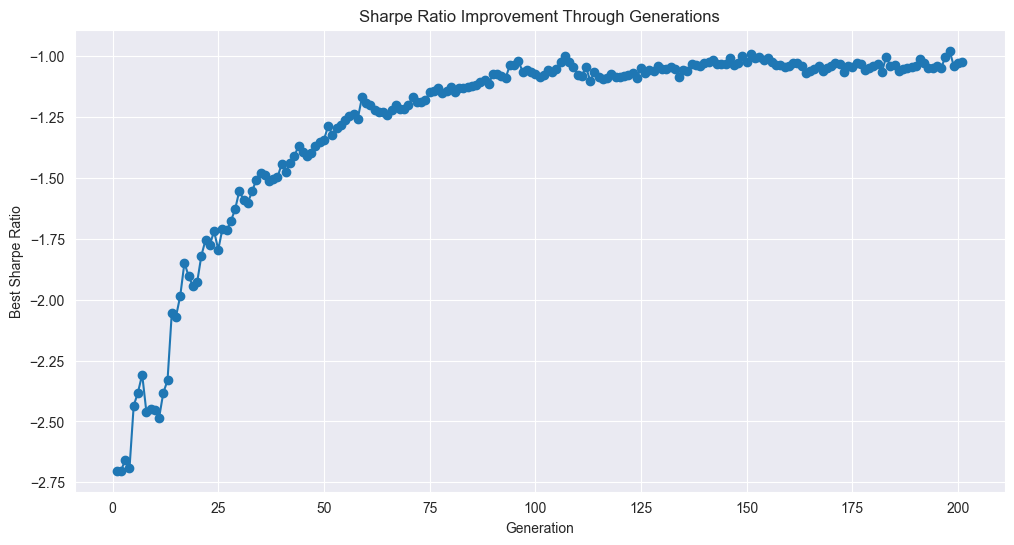

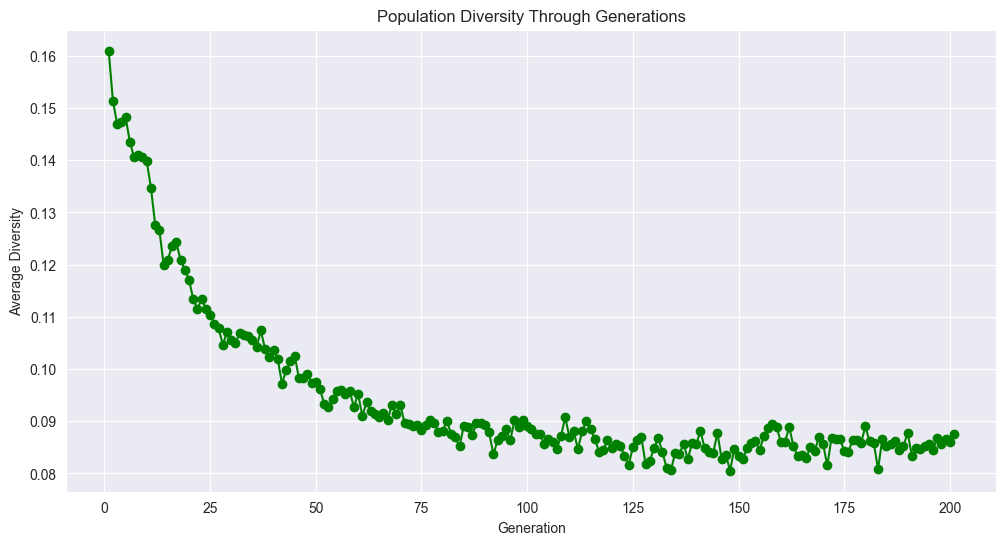

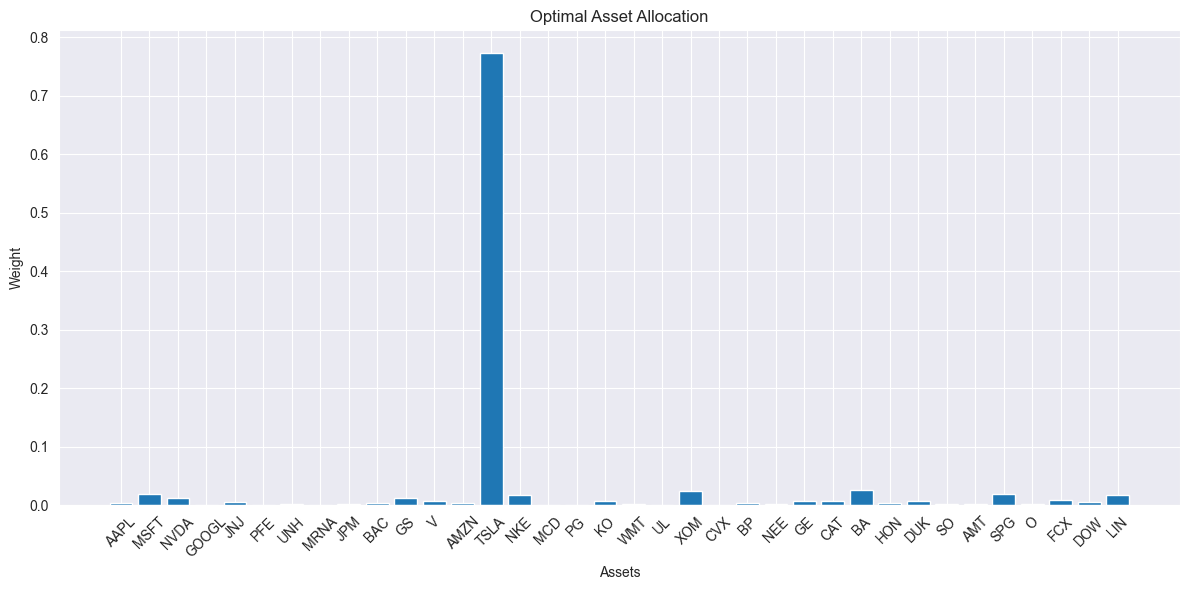

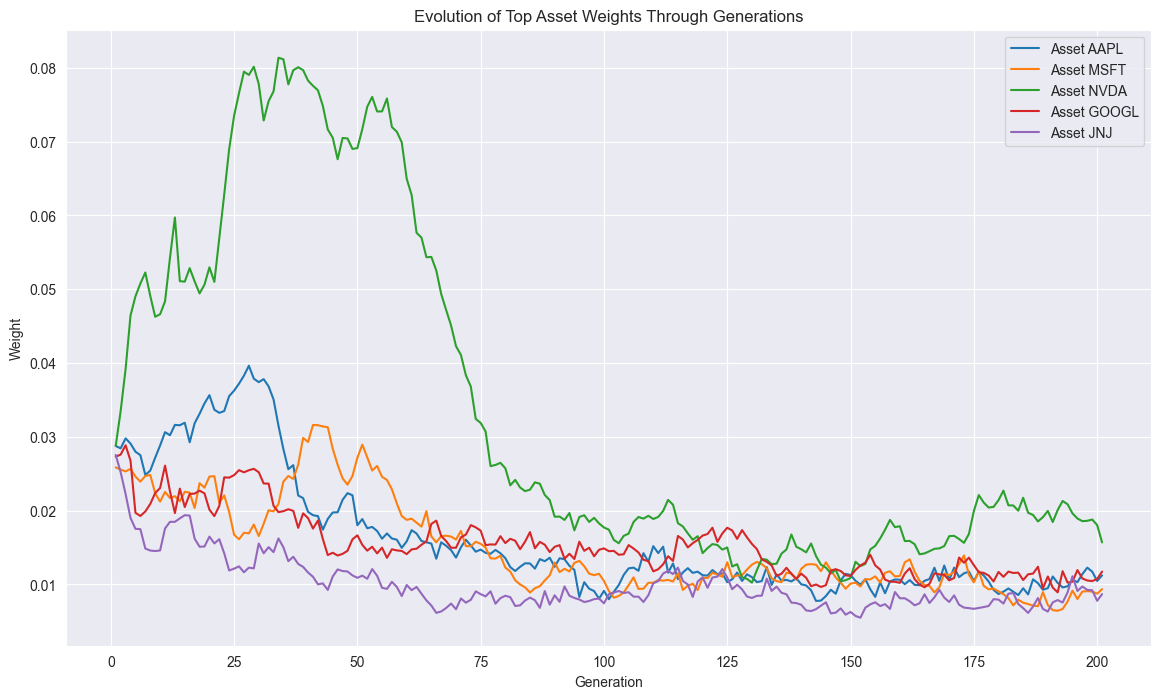

In [ ]:
def calculate_portfolio_statistics(data: pd.DataFrame, weights: np.ndarray):
    """
    Calculates the portfolio's covariance matrix, expected return, and standard deviation from price data.
    
    :param data: DataFrame with historical price data of assets (columns = assets, rows = time periods)
    :param weights: Numpy array of asset weights in the portfolio
    :return: covariance matrix, expected return, standard deviation
    """
    # CSV'den okunan verileri sayısal değerlere dönüştür
    numeric_data = data.apply(pd.to_numeric, errors='coerce')
    
    # Eksik değerleri temizle (dönüştürme sırasında ortaya çıkabilecek NaN değerler)
    numeric_data = numeric_data.dropna(axis=1, how='all')
    
    # Logaritmik getirileri hesapla
    returns = np.log(numeric_data / numeric_data.shift(1)).dropna()
    
    mean_returns = returns.mean()
    
    expected_return = np.dot(weights, mean_returns)
    covariance_matrix = returns.cov()
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    return covariance_matrix, expected_return, portfolio_std_dev

def calculate_sharpe_ratio(expected_return: float, portfolio_std_dev: float, risk_free_rate: float):
    """
    Calculates the Sharpe Ratio of the portfolio.
    """
    return (expected_return - risk_free_rate) / portfolio_std_dev

def fitness_function(weights: np.ndarray, data: pd.DataFrame, risk_free_rate: float):
    """
    Fitness function to optimize the portfolio using the Sharpe Ratio.
    """
    _, expected_return, portfolio_std_dev = calculate_portfolio_statistics(data, weights)
    sharpe_ratio = calculate_sharpe_ratio(expected_return, portfolio_std_dev, risk_free_rate)
    return -sharpe_ratio

def select_top_half_weights(weight_arrays: np.ndarray, data: pd.DataFrame, risk_free_rate: float):
    """
    Selects the top half of the weight arrays based on their fitness scores.
    """
    scores = np.array([fitness_function(weights, data, risk_free_rate) for weights in weight_arrays])
    sorted_indices = np.argsort(scores)
    top_half_indices = sorted_indices[:len(sorted_indices) // 2]

    selected_weights = weight_arrays[top_half_indices]
    selected_weights = np.array([w / np.sum(w) for w in selected_weights])
    
    # Yeni eklenen kısım: En iyi fitness değerini ve ağırlıklarını döndür
    best_fitness = scores[sorted_indices[0]]
    best_weights_in_generation = weight_arrays[sorted_indices[0]]
    
    return selected_weights, best_fitness, best_weights_in_generation

def arithmetic_crossover(selected_weights: np.ndarray):
    """
    Performs arithmetic crossover on selected weight arrays.
    """
    num_selected = selected_weights.shape[0]
    new_weights = []
    crossover_points = []  # Hangi bireylerin çaprazlandığının takibi
    
    for _ in range(num_selected):
        parent_indices = np.random.choice(num_selected, 2, replace=False)
        parents = selected_weights[parent_indices]
        alpha = np.random.rand()
        child = alpha * parents[0] + (1 - alpha) * parents[1]
        child = child / np.sum(child)
        new_weights.append(child)
        crossover_points.append((parent_indices, alpha))
        
    return np.vstack((selected_weights, np.array(new_weights))), crossover_points

def mutate_weights(weight_arrays: np.ndarray, mutation_rate=0.1):
    """
    Mutates weight arrays by swapping randomly chosen weights.
    """
    num_arrays, num_assets = weight_arrays.shape
    
    # Mutasyon sayısını takip et
    mutation_count = 0
    
    # Her ağırlık için mutation_rate olasılığıyla mutasyon uygula
    mutation_mask = np.random.random(size=(num_arrays, num_assets)) < mutation_rate
    
    if np.any(mutation_mask):
        mutation_count = np.sum(mutation_mask)
        
        # Mutasyona uğrayacak ağırlıklar
        for i in range(num_arrays):
            if np.any(mutation_mask[i]):
                # Mutasyona uğrayacak ağırlıklar için küçük rastgele değişimler uygula
                # Burada swap yerine küçük rastgele değişimleri izlemek daha kolay
                mutation_values = np.random.normal(0, 0.05, size=num_assets)
                weight_arrays[i] = weight_arrays[i] + mutation_values * mutation_mask[i]
                
                # Negatif değerleri 0 yap
                weight_arrays[i] = np.maximum(weight_arrays[i], 0)
                
                # Toplamın 1 olmasını sağla
                weight_arrays[i] = weight_arrays[i] / np.sum(weight_arrays[i])
    
    # Tüm ağırlıkların toplamının 1 olmasını garantile
    weight_arrays /= weight_arrays.sum(axis=1, keepdims=True)
    
    return weight_arrays, mutation_count

def initialize_first_generation(size: int, num_stocks: int):
    """
    Initializes the first generation of weight arrays.
    """
    return np.random.dirichlet(np.ones(num_stocks), size)

def calculate_population_diversity(population):
    """
    Popülasyon çeşitliliğini ölçer - farklı çözümlerin ne kadar birbirinden farklı olduğunu gösterir.
    """
    # Ortalama ağırlık vektörü
    mean_weights = np.mean(population, axis=0)
    
    # Her bireyin ortalamadan sapmasını hesapla
    deviations = np.sqrt(np.sum((population - mean_weights)**2, axis=1))
    
    # Ortalama sapma - çeşitlilik ölçütü
    avg_deviation = np.mean(deviations)
    max_deviation = np.max(deviations)
    min_deviation = np.min(deviations)
    
    return {
        'average_diversity': avg_deviation,
        'max_distance': max_deviation,
        'min_distance': min_deviation
    }

def calculate_asset_allocation_stats(population):
    """
    Varlık tahsisi istatistiklerini hesaplar - hangi varlıkların daha çok tercih edildiğini gösterir.
    """
    # Her varlık için ortalama ağırlık
    mean_weights = np.mean(population, axis=0)
    
    # Her varlık için standart sapma
    std_weights = np.std(population, axis=0)
    
    # En yüksek ağırlığa sahip varlıklar
    top_assets = np.argsort(-mean_weights)
    
    # En düşük standart sapmaya sahip varlıklar (daha kararlı tercihler)
    most_stable = np.argsort(std_weights)
    
    return {
        'mean_weights': mean_weights,
        'std_weights': std_weights,
        'top_assets': top_assets,
        'most_stable_assets': most_stable
    }

def optimize_portfolio(data: pd.DataFrame, risk_free_rate: float, population_size: int, generations: int):
    """
    Optimizes the portfolio using a genetic algorithm.
    """
    num_stocks = data.shape[1]
    population = initialize_first_generation(population_size, num_stocks)
    print("FIRST GENERATION IS GENERATED")
    
    # İzleme için gerekli veri yapıları
    generation_stats = []
    best_sharpe_ratios = []
    best_weights_history = []
    
    # İlk jenerasyon istatistikleri
    selected, best_fitness, best_weights_in_gen = select_top_half_weights(population, data, risk_free_rate)
    best_sharpe = -best_fitness  # Fitness negatif Sharpe olduğu için işareti değiştir
    
    best_sharpe_ratios.append(best_sharpe)
    best_weights_history.append(best_weights_in_gen)
    
    diversity = calculate_population_diversity(population)
    allocation = calculate_asset_allocation_stats(population)
    
    # İlk jenerasyon istatistikleri
    generation_stats.append({
        'generation': 1,
        'best_sharpe': best_sharpe,
        'diversity': diversity,
        'top_assets': allocation['top_assets'][:3],  # İlk 3 en popüler varlık
        'asset_weights': allocation['mean_weights']
    })
    
    for generation in range(generations):
        # Seçim
        selected, best_fitness, best_weights_in_gen = select_top_half_weights(population, data, risk_free_rate)
        best_sharpe = -best_fitness  # Fitness negatif Sharpe olduğu için işareti değiştir
        
        # Çaprazlama
        population, crossover_stats = arithmetic_crossover(selected)
        
        # Mutasyon
        population, mutation_count = mutate_weights(population)
        
        # Jenerasyon istatistiklerini topla
        diversity = calculate_population_diversity(population)
        allocation = calculate_asset_allocation_stats(population)
        
        # En iyi Sharpe oranını sakla
        best_sharpe_ratios.append(best_sharpe)
        best_weights_history.append(best_weights_in_gen)
        
        # Jenerasyon istatistiklerini sakla
        generation_stats.append({
            'generation': generation + 2,
            'best_sharpe': best_sharpe,
            'mutation_count': mutation_count,
            'diversity': diversity,
            'top_assets': allocation['top_assets'][:3],
            'asset_weights': allocation['mean_weights']
        })
        
        print(f"Generation {generation+2} is generated!")
        print(f"Best Sharpe Ratio: {best_sharpe:.4f} | Diversity: {diversity['average_diversity']:.4f} | Mutations: {mutation_count}")
        
    # Son jenerasyonun en iyi ağırlıklarını seç
    best_weights, _, _ = select_top_half_weights(population, data, risk_free_rate)
    best_weights = best_weights[0]
    
    # Tüm jenerasyon istatistiklerini DataFrame'e dönüştür
    import pandas as pd
    gen_df = pd.DataFrame([
        {
            'Generation': stat['generation'],
            'Best_Sharpe': stat['best_sharpe'],
            'Diversity': stat['diversity']['average_diversity'],
            'Top_Assets': stat['top_assets']
        }
        for stat in generation_stats
    ])
    
    # Sonuçları görselleştir
    import matplotlib.pyplot as plt
    
    # Sharpe Oranı Gelişimi
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(best_sharpe_ratios)+1), best_sharpe_ratios, marker='o')
    plt.title('Sharpe Ratio Improvement Through Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Sharpe Ratio')
    plt.grid(True)
    plt.savefig('sharpe_ratio_evolution.png')
    
    # Popülasyon Çeşitliliği
    diversity_values = [stat['diversity']['average_diversity'] for stat in generation_stats]
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(diversity_values)+1), diversity_values, marker='o', color='green')
    plt.title('Population Diversity Through Generations')
    plt.xlabel('Generation')
    plt.ylabel('Average Diversity')
    plt.grid(True)
    plt.savefig('population_diversity.png')
    
    # En İyi Varlık Dağılımı (Son Jenerasyon)
    final_weights = best_weights_history[-1]
    assets = data.columns if hasattr(data, 'columns') else [f'Asset {i+1}' for i in range(num_stocks)]
    
    plt.figure(figsize=(12, 6))
    plt.bar(assets, final_weights)
    plt.title('Optimal Asset Allocation')
    plt.xlabel('Assets')
    plt.ylabel('Weight')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('optimal_asset_allocation.png')
    
    # Varlık Ağırlıklarının Jenerasyonlar Boyunca Değişimi
    asset_weight_history = np.array([stat['asset_weights'] for stat in generation_stats])
    
    plt.figure(figsize=(14, 8))
    for i in range(min(5, num_stocks)):  # İlk 5 varlığı göster (çok sayıda varlık varsa)
        plt.plot(range(1, len(asset_weight_history)+1), asset_weight_history[:, i], 
                label=f'Asset {assets[i] if i < len(assets) else i+1}')
    
    plt.title('Evolution of Top Asset Weights Through Generations')
    plt.xlabel('Generation')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.savefig('asset_weight_evolution.png')
    
    # Excel dosyasına tüm verileri kaydet
    with pd.ExcelWriter('genetic_algorithm_results.xlsx') as writer:
        # Jenerasyon özeti
        gen_df.to_excel(writer, sheet_name='Generation_Summary', index=False)
        
        # En iyi ağırlıklar tarihçesi
        weights_df = pd.DataFrame(best_weights_history, 
                                 columns=[f'Asset_{i+1}' for i in range(num_stocks)])
        weights_df['Generation'] = range(1, len(best_weights_history)+1)
        weights_df['Sharpe_Ratio'] = best_sharpe_ratios
        weights_df.to_excel(writer, sheet_name='Best_Weights_History', index=False)
        
        # Son optimal ağırlıklar
        final_weights_df = pd.DataFrame({
            'Asset': assets,
            'Weight': best_weights
        })
        final_weights_df.to_excel(writer, sheet_name='Final_Optimal_Weights', index=False)
    
    return best_weights, best_sharpe_ratios, gen_df

# Kullanım
# CSV dosyasını oku ve sayısal verilere dönüştür
data = pd.read_csv('close_prices.csv', index_col=0)  # İlk sütun tarih ise index_col=0 kullanın
data = data.apply(pd.to_numeric, errors='coerce')
print(f"Veri boyutu: {data.shape}, Veri tipleri: {data.dtypes.unique()}")

# Herhangi bir sütun ya da satırda tamamıyla eksik değer varsa temizle
data = data.dropna(axis=1, how='all')  # Tamamen NaN olan sütunları kaldır
data = data.dropna(axis=0, how='all')  # Tamamen NaN olan satırları kaldır

# Kalan eksik değerleri doldur (opsiyonel)
if data.isnull().values.any():
    print(f"Veri setinde {data.isnull().sum().sum()} adet eksik değer var. Bunlar doldurulacak.")
    data = data.fillna(method='ffill')  # İleri doğru doldurma

# Hata ayıklama için veri önizlemesi
print("\nİlk 5 satır:")
print(data.head())

population_size = 300
iterations = 200 # jenerasyon sayısı
best_weights, sharpe_history, generation_stats = optimize_portfolio(data, risk_free_rate=0.03, population_size=population_size, generations=iterations)

_, expected_return, portfolio_std_dev = calculate_portfolio_statistics(data, best_weights)
sharpe_ratio = calculate_sharpe_ratio(expected_return, portfolio_std_dev, 0.03)

print("\n" + "="*50)
print("ÖZET SONUÇLAR")
print("="*50)
print("Best weights:", best_weights)
print("Final Sharpe Ratio:", sharpe_ratio)
print("İlk Sharpe Ratio:", sharpe_history[0])
print("İyileşme Oranı: %{:.2f}".format((sharpe_ratio - sharpe_history[0]) / sharpe_history[0] * 100))
print("\nGrafikler ve ayrıntılı veriler şu dosyalara kaydedildi:")
print("- sharpe_ratio_evolution.png")
print("- population_diversity.png")
print("- optimal_asset_allocation.png")
print("- asset_weight_evolution.png")
print("- genetic_algorithm_results.xlsx")